In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
sbn.set_style('darkgrid')

In [3]:
dataset = pd.read_csv("https://raw.githubusercontent.com/benvictoria17/Finance/main/dataset/Auto%20Insurance%20in%20Sweden/swedish_insurance.csv")

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       63 non-null     int64  
 1   Y       63 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.1 KB


In [5]:
dataset = dataset.drop_duplicates()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63 entries, 0 to 62
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       63 non-null     int64  
 1   Y       63 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.5 KB


In [6]:
dataset = dataset.rename(columns = {'X':'Num_Claims', 'Y':'Total_payments'})
X = pd.DataFrame(data = dataset['Num_Claims'])
y = pd.DataFrame(data = dataset['Total_payments'])

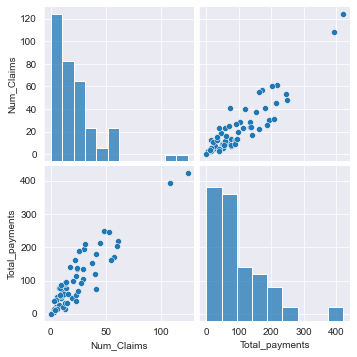

In [7]:
sbn.pairplot(dataset)

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


Average R2 of baseline model:  0.7781234814636606


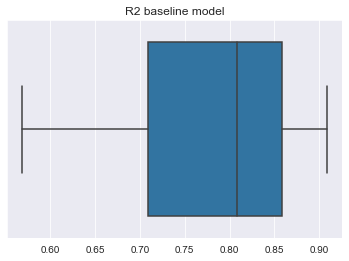

In [9]:
cv = RepeatedKFold(n_splits = 2, n_repeats =15, random_state = 0)
baseline_score = cross_val_score(LinearRegression(), X, y, scoring = 'r2', cv = cv, n_jobs = -1)
sbn.boxplot(baseline_score, orient = 'v').set_title('R2 baseline model')
print('Average R2 of baseline model: ', np.mean(baseline_score))

<AxesSubplot:xlabel='variable', ylabel='value'>

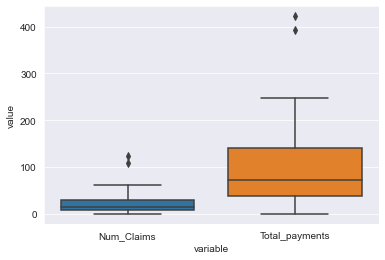

In [10]:
sbn.boxplot(x = 'variable', y = 'value', data = pd.melt(dataset))

In [11]:
number_outliers = []
limits = [0.75,0.80,0.90,0.95,0.99]
for i in  limits:
    are_outliers = X > np.quantile(X, i)
    X_noout = np.ma.masked_array(data = X, mask = are_outliers)
    X_noout = np.ma.compressed(X_noout)
    number_outliers.append(round((X.shape[0] - X_noout.shape[0])/X.shape[0],2)*100)

number_outliers

[24.0, 21.0, 11.0, 6.0, 2.0]

Text(0.5, 1.0, 'R2 of baseline model (left), and no-outliers model (right)')

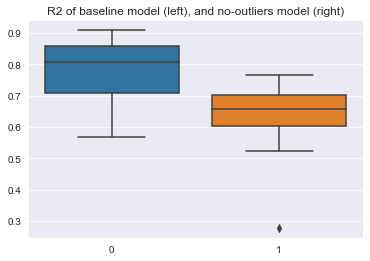

In [14]:
X_noout = np.ma.masked_array(data = X, mask = X>np.quantile(X,0.95))
y_noout = np.ma.masked_array(data = y, mask = X>np.quantile(X,0.95))
X_noout = np.ma.compressed(X_noout)
y_noout = np.ma.compressed(y_noout)
cv = RepeatedKFold(n_splits = 2, n_repeats =15, random_state = 0)
nooutlier_score = cross_val_score(LinearRegression(), X_noout.reshape(-1,1), y_noout.reshape(-1,1), scoring = 'r2', cv = cv, n_jobs = -1)
sbn.boxplot(data = [baseline_score,nooutlier_score]).set_title('R2 of baseline model (left), and no-outliers model (right)')

In [15]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

params_lasso = {'alpha': [0,0.05,0.10, 0.20, 0.30, 0.50, 0.70, 1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 18, 19, 20]}
grid_lasso = GridSearchCV(estimator = Lasso(), param_grid = params_lasso,scoring = 'r2',cv = 5, refit = True, verbose = 3,n_jobs = -1)
grid_lasso.fit(X, y)
print('Best Lasso parameter: ', grid_lasso.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Lasso parameter:  {'alpha': 18}


In [16]:
from sklearn.ensemble import RandomForestRegressor
params_forest = {'n_estimators': [50, 100, 150],
                 'criterion':['mse', 'mae'],
                 'max_depth': [2, 5, 10, 20, 30], 
                 'min_samples_split':[2, 5, 8, 10, 15, 20, 25, 30, 50], 
                 'min_samples_leaf': [2, 3, 4, 5, 6, 10, 20] 
                }
grid_forest = GridSearchCV(estimator = RandomForestRegressor(), param_grid = params_forest,scoring = 'r2',cv = 5, refit = True, verbose = 3, n_jobs = -1)
grid_forest.fit(X, y)
print('Best Random Forest parameter: ', grid_forest.best_params_)

Fitting 5 folds for each of 1890 candidates, totalling 9450 fits
Best Random Forest parameter:  {'criterion': 'mae', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 50}


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [18]:
models = []
models.append(('Baseline', LinearRegression()))
models.append(('Lasso', Lasso(alpha = 18)))
models.append(('RandomForest', RandomForestRegressor(criterion  = 'mae', max_depth = 5, min_samples_leaf = 3, min_samples_split = 15, n_estimators = 50)))
results = []
names = []
scoring = 'r2'
for name, model in models:
    kfold = RepeatedKFold(n_splits = 2, n_repeats = 10, random_state = 0)
    cv_results = cross_val_score(model, X, y, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    print('R2 of: ',name, '= ',cv_results.mean())

R2 of:  Baseline =  0.7714604862514559
R2 of:  Lasso =  0.7704162910527236


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 

R2 of:  RandomForest =  0.44405293825374337


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


<AxesSubplot:xlabel='variable', ylabel='value'>

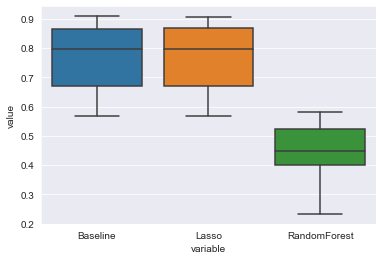

In [19]:
results_final = pd.DataFrame(results).T
results_final.set_axis(names, axis = 1, inplace = True)
sbn.boxplot(x = 'variable', y = 'value', data = pd.melt(results_final))